In [38]:
!pip install fastai2

In [39]:
!pip install fastcore==0.1.35

In [40]:
!pip install torch==1.6.0 torchvision==0.7.0

# Fastai Tutorial - Transformer
In this tutorial, we will see how we can use the fastai library to fine-tune a pretrained transformer model from the [transformers library](https://github.com/huggingface/transformers) by HuggingFace. We will use the mid-level API to gather the data. Even if this tutorial is self contained, it might help to check the imagenette tutorial to have a second look on the mid-level API (with a gentle introduction using the higher level APIs) in computer vision.

## Importing a transformers pretrained model
First things first, we will need to install the transformers library. If you haven't done it yet, install the library:

In [41]:
!pip install -Uq transformers

Then let's import what will need: we will fine-tune the GPT2 pretrained model and fine-tune on wikitext-2 here. For this, we need the `GPT2LMHeadModel` (since we want a language model) and the `GPT2Tokenizer` to prepare the data.

In [42]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

We can use several versions of this GPT2 model, look at the [transformers documentation](https://huggingface.co/transformers/pretrained_models.html) for more details. Here we will use the basic version (that already takes a lot of space in memory!) You can change the model used by changing the content of `pretrained_weights` (if it's not a GPT2 model, you'll need to change the classes used for the model and the tokenizer of course).

In [43]:
pretrained_weights = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

Before we move on to the fine-tuning part, let's have a look at this tokenizer and this model. The `tokenizers` in HuggingFace usually do the tokenization and the numericalization in one step (we ignore the padding warning for now):

In [44]:
ids = tokenizer.encode("hello, my name is John")
ids

[31373, 11, 616, 1438, 318, 1757]

Like fastai `Transform`s, the tokenizer has a decode method to give you back a text from ids:

In [45]:
tokenizer.decode(ids)

'hello, my name is John'

The model can be used to generate predictions (it is pretrained). It has a generate method that expects a batch of prompt, so we feed it our ids and add one batch dimension (there is a padding warning we can ignore as well):

In [46]:
import torch

In [47]:
t = torch.LongTensor(ids)[None] # add one batch dimension
preds = model.generate(t)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [48]:
preds.shape, preds[0]

(torch.Size([1, 20]),
 tensor([31373,    11,   616,  1438,   318,  1757,    13,   314,  1101,   257,
          3710,   379,   262,  2059,   286,  3442,    11, 14727,    13,   314]))

In [49]:
tokenizer.decode(preds[0].numpy())

"hello, my name is John. I'm a student at the University of California, Berkeley. I"

## Bridging the gap with fastai
Now let's see how we can use fastai to fine-tune this model on wikitext-2, using all the training utilities (learning rate finder, 1cycle policy etc...). First, we import all the text utilities:

In [50]:
from fastai2.text.all import *

### Preparing the data
Then we download the dataset (if not present), it comes as two csv files:

In [51]:
path = untar_data(URLs.WIKITEXT_TINY)
path.ls()

(#2) [Path('/root/.fastai/data/wikitext-2/test.csv'),Path('/root/.fastai/data/wikitext-2/train.csv')]

Let's have a look at what those csv files look like:

In [52]:
df_train = pd.read_csv(path/'train.csv', header=None)
df_test = pd.read_csv(path/'test.csv', header=None)
df_train.head()

,0
0,"\n = 2013 – 14 York City F.C. season = \n \n The 2013 – 14 season was the <unk> season of competitive association football and 77th season in the Football League played by York City Football Club , a professional football club based in York , North Yorkshire , England . Their 17th @-@ place finish in 2012 – 13 meant it was their second consecutive season in League Two . The season ran from 1 July 2013 to 30 June 2014 . \n Nigel Worthington , starting his first full season as York manager , made eight permanent summer signings . By the turn of the year York were only above the relegation z..."
1,"\n = Big Boy ( song ) = \n \n "" Big Boy "" <unk> "" I 'm A Big Boy Now "" was the first single ever recorded by the Jackson 5 , which was released by Steeltown Records in January 1968 . The group played instruments on many of their Steeltown compositions , including "" Big Boy "" . The song was neither a critical nor commercial success , but the Jackson family were delighted with the outcome nonetheless . \n The Jackson 5 would release a second single with Steeltown Records before moving to Motown Records . The group 's recordings at Steeltown Records were thought to be lost , but they were re..."
2,"\n = The Remix ( Lady Gaga album ) = \n \n The Remix is a remix album by American recording artist Lady Gaga . Released in Japan on March 3 , 2010 , it contains remixes of the songs from her first studio album , The Fame ( 2008 ) , and her third extended play , The Fame Monster ( 2009 ) . A revised version of the track list was prepared for release in additional markets , beginning with Mexico on May 3 , 2010 . A number of recording artists have produced the songs , including Pet Shop Boys , Passion Pit and The Sound of Arrows . The remixed versions feature both uptempo and <unk> composit..."
3,"\n = New Year 's Eve ( Up All Night ) = \n \n "" New Year 's Eve "" is the twelfth episode of the first season of the American comedy television series Up All Night . The episode originally aired on NBC in the United States on January 12 , 2012 . It was written by Erica <unk> and was directed by Beth McCarthy @-@ Miller . The episode also featured a guest appearance from Jason Lee as Chris and Reagan 's neighbor and Ava 's boyfriend , Kevin . \n During Reagan ( Christina Applegate ) and Chris 's ( Will <unk> ) first New Year 's Eve game night , Reagan 's competitiveness comes out causing Ch..."
4,"\n = Geopyxis carbonaria = \n \n Geopyxis carbonaria is a species of fungus in the genus Geopyxis , family <unk> . First described to science in 1805 , and given its current name in 1889 , the species is commonly known as the charcoal loving elf @-@ cup , dwarf <unk> cup , <unk> <unk> cup , or pixie cup . The small , <unk> @-@ shaped fruitbodies of the fungus are reddish @-@ brown with a whitish fringe and measure up to 2 cm ( 0 @.@ 8 in ) across . They have a short , tapered stalk . Fruitbodies are commonly found on soil where brush has recently been burned , sometimes in great numbers ...."


We gather all texts in one numpy array (since it will be easier to use this way with fastai):

In [53]:
# concat both dfs
all_texts = np.concatenate([df_train[0].values, df_test[0].values]) 

To process this data to train a model, we need to build a `Transform` that will be applied lazily. In this case we could do the pre-processing once and for all and only use the transform for decoding (we will see how just after), but the fast tokenizer from HuggingFace is, as its name indicates, fast, so it doesn't really impact performance to do it this way.

In a fastai `Transform` you can define:

- an `encodes` method that is applied when you call the transform (a bit like the `forward` method in a `nn.Module`)
- a `decodes` method that is applied when you call the `decode` method of the transform, if you need to decode anything for showing purposes (like converting ids to a text here)
- a `setups` method that sets some inner state of the `Transform` (not needed here so we skip it)

In [54]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

Two comments on the code above:

- in `encodes` we don't use the `tokenizer.encode` method since it does some additional preprocessing for the model after tokenizing and numericalizing (the part throwing a warning before). Here we don't need any post-processing so it's fine to skip it.
- in `decodes` we return a `TitledStr` object and not just a plain string. That's a fastai class that adds a show method to the string, which will allow us to use all the fastai show methods.

You can then group your data with this `Transform` using a `TfmdLists`. It has an s in its name because it contains the training and validation set. We indicate the indices of the training set and the validation set with splits (here all the first indices until `len(df_train)` and then all the remaining indices):

In [55]:
splits = [range_of(df_train), list(range(len(df_train), len(all_texts)))]
tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

We specify `dl_type=LMDataLoader` for when we will convert this `TfmdLists` to `DataLoaders`: we will use an `LMDataLoader` since we have a language modeling problem, not the usual fastai `TfmdDL`.

In a `TfmdLists` you can access the elements of the training or validation set quite easily:

In [56]:
tls.train[0], tls.valid[0]

(tensor([220, 198, 796,  ..., 198, 220, 198]),
 tensor([220, 198, 796,  ..., 198, 220, 198]))

They look the same but only because they begin and end the same way. We can see the shapes are different:

In [57]:
tls.tfms(tls.train.items[0]).shape, tls.tfms(tls.valid.items[0]).shape

(torch.Size([4576]), torch.Size([1485]))

And we can have a look at both decodes using show_at:

In [58]:
show_at(tls.train, 0)

 
 = 2013 – 14 York City F.C. season = 
 
 The 2013 – 14 season was the <unk> season of competitive association football and 77th season in the Football League played by York City Football Club, a professional football club based in York, North Yorkshire, England. Their 17th @-@ place finish in 2012 – 13 meant it was their second consecutive season in League Two. The season ran from 1 July 2013 to 30 June 2014. 
 Nigel Worthington, starting his first full season as York manager, made eight permanent summer signings. By the turn of the year York were only above the relegation zone on goal difference, before a 17 @-@ match unbeaten run saw the team finish in seventh @-@ place in the 24 @-@ team 2013 – 14 Football League Two. This meant York qualified for the play @-@ offs, and they were eliminated in the semi @-@ final by Fleetwood Town. York were knocked out of the 2013 – 14 FA Cup, Football League Cup and Football League Trophy in their opening round matches. 
 35 players made at least

The fastai library expects the data to be assembled in a `DataLoaders` object (something that has a training and validation dataloader). We can get one by using the `dataloaders` method. We just have to specify a batch size and a sequence length. We'll train with sequences of size 256 (GPT2 used sequence length 1024, but not everyone has enough GPU RAM for that):

In [59]:
bs, sl = 4, 256
dls = tls.dataloaders(bs=bs, seq_len=sl)

Note that you may have to reduce the batch size depending on your GPU RAM.

In fastai, as soon as we have a `DataLoaders`, we can use `show_batch` to have a look at the data (here texts for inputs, and the same text shifted by one token to the right for validation):

In [60]:
dls.show_batch(max_n=2)

,text,text_
0,"\n = Kakapo = \n \n The kakapo ( Māori : kākāpō or night parrot ), <unk> <unk> ( Gray, 1845 ), also called owl parrot, is a species of large, flightless, nocturnal, ground @-@ dwelling parrot of the super @-@ family <unk> endemic to New Zealand. \n It has finely blotched yellow @-@ green plumage, a distinct facial disc of sensory, <unk> @-@ like feathers, a large grey beak, short legs, large feet, and wings and a tail of relatively short length. A combination of traits make it unique among its kind ; it is the world's only flightless parrot, the heaviest parrot, nocturnal, herbivorous, visibly sexually dimorphic in body size, has a low basal metabolic rate and no male parental care, and is the only parrot to have a <unk> lek breeding system. It is also possibly one of the world's longest @-@ living birds. Its anatomy","\n = Kakapo = \n \n The kakapo ( Māori : kākāpō or night parrot ), <unk> <unk> ( Gray, 1845 ), also called owl parrot, is a species of large, flightless, nocturnal, ground @-@ dwelling parrot of the super @-@ family <unk> endemic to New Zealand. \n It has finely blotched yellow @-@ green plumage, a distinct facial disc of sensory, <unk> @-@ like feathers, a large grey beak, short legs, large feet, and wings and a tail of relatively short length. A combination of traits make it unique among its kind ; it is the world's only flightless parrot, the heaviest parrot, nocturnal, herbivorous, visibly sexually dimorphic in body size, has a low basal metabolic rate and no male parental care, and is the only parrot to have a <unk> lek breeding system. It is also possibly one of the world's longest @-@ living birds. Its anatomy <unk>"
1,", and 1939. \n Whereas Hergé's use of Chinese in The Blue Lotus was correct, the Arabic script employed in The Crab with the Golden Claws was intentionally fictitious. Many of the place names featured in the series are puns : the town of <unk> was a pun on the French Que <unk>? ( "" what is to be done? "" ) while the port of <unk> derives from the French <unk> ( scrape, or fight ). The name of Omar ben Salaad is a pun meaning "" <unk> <unk> "" in French. \n In February 1942, Casterman suggested to Hergé that his books be published in a new format ; 62 @-@ pages rather than the former 100 to 130 pages, and now in full colour rather than black @-@ and @-@ white. He agreed to this, and in 1943 The Crab with the Golden Claws was re @-@","and 1939. \n Whereas Hergé's use of Chinese in The Blue Lotus was correct, the Arabic script employed in The Crab with the Golden Claws was intentionally fictitious. Many of the place names featured in the series are puns : the town of <unk> was a pun on the French Que <unk>? ( "" what is to be done? "" ) while the port of <unk> derives from the French <unk> ( scrape, or fight ). The name of Omar ben Salaad is a pun meaning "" <unk> <unk> "" in French. \n In February 1942, Casterman suggested to Hergé that his books be published in a new format ; 62 @-@ pages rather than the former 100 to 130 pages, and now in full colour rather than black @-@ and @-@ white. He agreed to this, and in 1943 The Crab with the Golden Claws was re @-@"


Another way to gather the data is to preprocess the texts once and for all and only use the transform to decode the tensors to texts:

In [61]:
def tokenize(text):
    toks = tokenizer.tokenize(text)
    return tensor(tokenizer.convert_tokens_to_ids(toks))

tokenized = [tokenize(t) for t in progress_bar(all_texts)]

Now we change the previous `Tokenizer` like this:

In [62]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        return x if isinstance(x, Tensor) else tokenize(x) # in cacse the input is nnot tokenized
        
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In the `encodes` method, we still account for the case where we get something that's not already tokenized, just in case we were to build a dataset with new texts using this transform.

In [63]:
tls = TfmdLists(tokenized, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
dls = tls.dataloaders(bs=bs, seq_len=sl)

In [64]:
dls.show_batch(max_n=2)

,text,text_
0,"\n = Battle of Romani = \n \n The Battle of Romani was the last ground attack of the Central Powers on the Suez Canal at the beginning of the Sinai and Palestine Campaign during the First World War. The battle was fought between 3 and 5 August 1916 near the Egyptian town of Romani and the site of ancient Pelusium on the Sinai Peninsula, 23 miles ( 37 km ) east of the Suez Canal. This victory by the 52nd ( Lowland ) Division and the Anzac Mounted Division of the Egyptian Expeditionary Force ( EEF ) over a joint Ottoman and German force, which had marched across the Sinai, marked the end of the Defence of the Suez Canal campaign, also known as the Offensive zur <unk> des <unk> and the <unk> <unk> <unk>, which had begun on 26 January 1915. \n This British Empire victory, the","\n = Battle of Romani = \n \n The Battle of Romani was the last ground attack of the Central Powers on the Suez Canal at the beginning of the Sinai and Palestine Campaign during the First World War. The battle was fought between 3 and 5 August 1916 near the Egyptian town of Romani and the site of ancient Pelusium on the Sinai Peninsula, 23 miles ( 37 km ) east of the Suez Canal. This victory by the 52nd ( Lowland ) Division and the Anzac Mounted Division of the Egyptian Expeditionary Force ( EEF ) over a joint Ottoman and German force, which had marched across the Sinai, marked the end of the Defence of the Suez Canal campaign, also known as the Offensive zur <unk> des <unk> and the <unk> <unk> <unk>, which had begun on 26 January 1915. \n This British Empire victory, the first"
1,"satellite for which human exploration is feasible. The levels of ionizing radiation on Io, Europa, and Ganymede are hostile to human life, and adequate protective measures have yet to be devised. \n It could be possible to build a surface base that would produce fuel for further exploration of the Solar System. In 1997, the <unk> Project designed a plan to <unk> Europa. According to this plan, explorers would drill down into the Europan ice crust, entering the postulated subsurface ocean, where they would inhabit artificial air pockets. \n \n Key : Pld \n = Played, W = \n \n = L.A.M.B. = \n \n L.A.M.B. is a fashion line by American singer Gwen Stefani, the lead vocalist of the rock band No Doubt. The line manufactures apparel and fashion accessories. It was founded in 2003 and made its runway debut in 2004. The fashion line manufactures accessories like","for which human exploration is feasible. The levels of ionizing radiation on Io, Europa, and Ganymede are hostile to human life, and adequate protective measures have yet to be devised. \n It could be possible to build a surface base that would produce fuel for further exploration of the Solar System. In 1997, the <unk> Project designed a plan to <unk> Europa. According to this plan, explorers would drill down into the Europan ice crust, entering the postulated subsurface ocean, where they would inhabit artificial air pockets. \n \n Key : Pld \n = Played, W = \n \n = L.A.M.B. = \n \n L.A.M.B. is a fashion line by American singer Gwen Stefani, the lead vocalist of the rock band No Doubt. The line manufactures apparel and fashion accessories. It was founded in 2003 and made its runway debut in 2004. The fashion line manufactures accessories like shoes,"


### Fine-tuning the model
The HuggingFace model will return a tuple in outputs, with the actual predictions and some additional activations (should we want to use them in some regularization scheme). To work inside the fastai training loop, we will need to drop those using a `Callback`: we use those to alter the behavior of the training loop.

Here we need to write the event `after_pred` and replace `self.learn.pred` (which contains the predictions that will be passed to the loss function) by just its first element. In `callbacks`, there is a shortcut that lets you access any of the underlying `Learner` attributes so we can write `self.pred[0]` instead of `self.learn.pred[0]`. **That shortcut only works for read access, not write**, so we have to write `self.learn.pred` on the right side (otherwise we would set a pred attribute in the `Callback`).

In [65]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

Of course we could make this a bit more complex and add some penalty to the loss using the other part of the tuple of predictions, like the `RNNRegularizer`.

Now, we are ready to create our `Learner`, which is a fastai object grouping data, model and loss function and handles model training or inference. Since we are in a language model setting, we pass perplexity as a metric, and we need to use the callback we just defined. Lastly, we use mixed precision to save every bit of memory we can (and if you have a modern GPU, it will also make training faster):

In [66]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

We can check how good the model is without any fine-tuning step (spoiler alert, it's pretty good!)

In [67]:
learn.validate()

(#2) [3.69620418548584,40.294063568115234]

This lists the validation loss and metrics (so 40.2 as perplexity is kind of amazing).

Now that we have a `Learner` we can use all the fastai training loop capabilities: learning rate finder, training with 1cycle etc...

SuggestedLRs(lr_min=0.0003019951749593019, lr_steep=0.00010964782268274575)

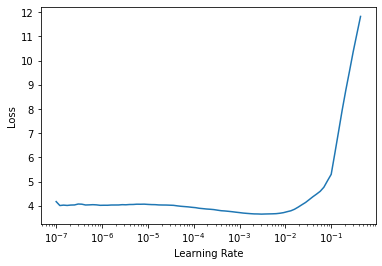

In [68]:
learn.lr_find()

The learning rate finder curve suggests picking something between 1e-4 and 1e-3.

In [69]:
learn.fit_one_cycle(1, 1e-4)

Now with just one epoch of fine-tuning and not much regularization, our model did not really improve since it was already amazing. To have a look at some generated texts, let's take a prompt that looks like a wikipedia article:

In [70]:
df_test.head(1)

,0
0,"\n = Tropical Storm <unk> ( 2008 ) = \n \n Tropical Storm <unk> was the tenth tropical storm of the 2008 Atlantic hurricane season . <unk> developed out of a strong tropical wave which moved off the African coast on August 31 . The wave quickly became organized and was declared Tropical Depression Ten while located 170 mi ( 270 km ) to the south @-@ southeast of the Cape Verde Islands on September 2 . The depression was quickly upgraded to Tropical Storm <unk> around noon the same day . Over the next several days , <unk> moved in a general west @-@ northwest direction and reached its peak..."


Article seems to begin with new line and the title between = signs, so we will mimic that:

In [71]:
prompt = '\n = Unicorn = \n \n A unicorn is a magical creature with a rainbow tail and a horn'

The prompt needs to be tokenized and numericalized, so we use the same function as before to do this, before we use the `generate` method of the model.

In [72]:
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 21])

In [73]:
preds = learn.model.generate(inp, max_length=40, num_beams=5, temperature=1.5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [74]:
tokenizer.decode(preds[0].cpu().numpy())

'\n = Unicorn = \n \n A unicorn is a magical creature with a rainbow tail and a horn.\n\nA unicorn is a magical creature with a rainbow tail.\n\n\nA unicorn'